# 01 - Magnetic Dipole Basics

This notebook introduces the magnetic dipole model that forms the foundation of
Pathfinder gradiometer simulation. We'll explore:

1. The magnetic dipole field equation
2. How field strength decays with distance (1/r³)
3. The vertical gradient measured by a gradiometer
4. Detection depth vs. target size
5. 3D visualization of dipole fields

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from geosim.magnetics.dipole import (
    MU_0, _PREFACTOR, dipole_field, dipole_field_gradient,
    dipole_moment_from_sphere, detection_depth_estimate,
    superposition_field, gradiometer_reading,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. The Magnetic Dipole Field

A magnetic dipole with moment **m** at position **r_src** produces a field at observation point **r_obs**:

$$\mathbf{B}(\mathbf{r}) = \frac{\mu_0}{4\pi} \frac{3(\mathbf{m} \cdot \hat{\mathbf{r}})\hat{\mathbf{r}} - \mathbf{m}}{|\mathbf{r}|^3}$$

where $\mu_0 = 4\pi \times 10^{-7}$ T·m/A is the vacuum permeability.

On the axis of a z-directed dipole:
- $B_z = \frac{\mu_0}{4\pi} \frac{2m}{r^3}$ (axial, stronger)
- $B_z = -\frac{\mu_0}{4\pi} \frac{m}{r^3}$ (equatorial, weaker, opposite sign)

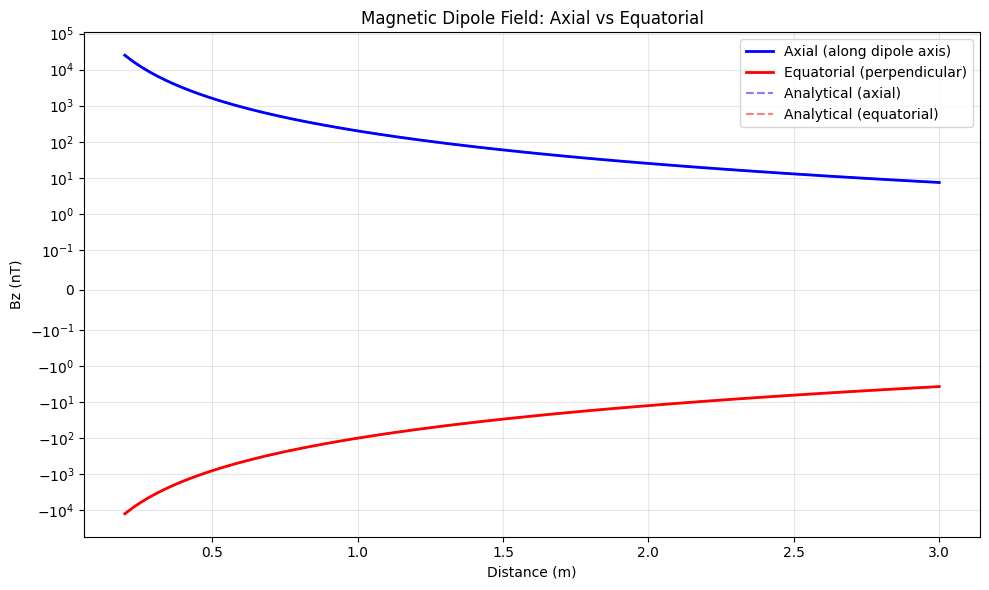

In [2]:
# Compute field along the axis and equatorial plane of a 1 A·m² dipole
moment = np.array([0.0, 0.0, 1.0])  # 1 A·m² along z
r_src = np.array([0.0, 0.0, 0.0])

distances = np.linspace(0.2, 3.0, 100)

# Axial field (along z-axis)
axial_points = np.column_stack([np.zeros(100), np.zeros(100), distances])
B_axial = dipole_field(axial_points, r_src, moment)
Bz_axial = B_axial[:, 2]

# Equatorial field (along x-axis)
equatorial_points = np.column_stack([distances, np.zeros(100), np.zeros(100)])
B_equatorial = dipole_field(equatorial_points, r_src, moment)
Bz_equatorial = B_equatorial[:, 2]

# Analytical formulas for comparison
Bz_axial_exact = _PREFACTOR * 2.0 / distances**3
Bz_equatorial_exact = -_PREFACTOR / distances**3

fig, ax = plt.subplots()
ax.plot(distances, Bz_axial * 1e9, 'b-', linewidth=2, label='Axial (along dipole axis)')
ax.plot(distances, Bz_equatorial * 1e9, 'r-', linewidth=2, label='Equatorial (perpendicular)')
ax.plot(distances, Bz_axial_exact * 1e9, 'b--', alpha=0.5, label='Analytical (axial)')
ax.plot(distances, Bz_equatorial_exact * 1e9, 'r--', alpha=0.5, label='Analytical (equatorial)')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Bz (nT)')
ax.set_title('Magnetic Dipole Field: Axial vs Equatorial')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('symlog', linthresh=0.1)
plt.tight_layout()

## 2. Inverse Cube Decay

The dipole field decays as $1/r^3$. This is the fundamental limitation on detection depth:
double the distance and the field drops by a factor of 8.

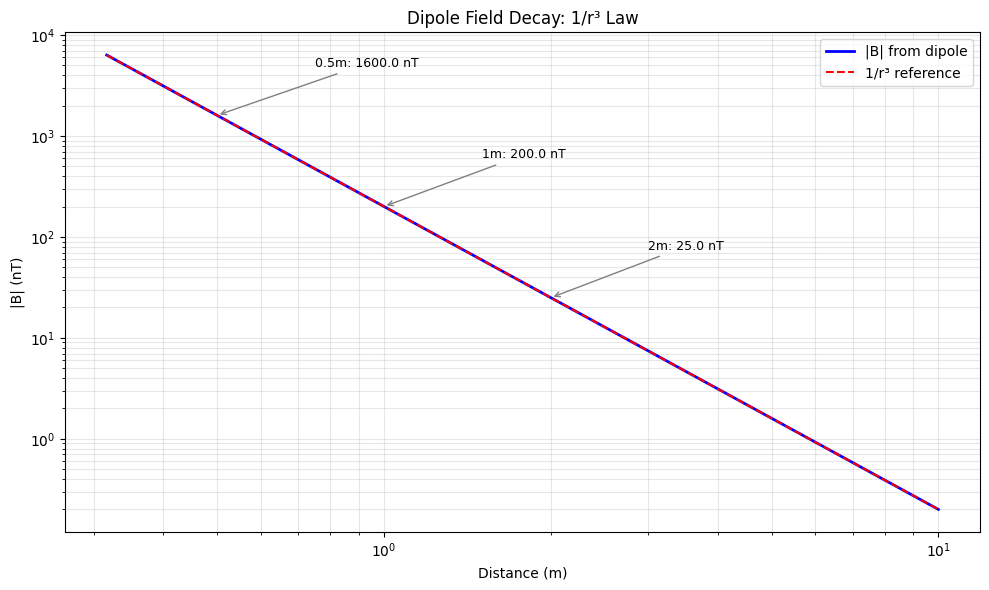

In [3]:
# Log-log plot showing 1/r³ decay
distances = np.logspace(-0.5, 1.0, 50)  # 0.3m to 10m
axial_points = np.column_stack([np.zeros(50), np.zeros(50), distances])
B = dipole_field(axial_points, r_src, moment)
B_magnitude = np.linalg.norm(B, axis=1)

fig, ax = plt.subplots()
ax.loglog(distances, B_magnitude * 1e9, 'b-', linewidth=2, label='|B| from dipole')
ax.loglog(distances, _PREFACTOR * 2.0 / distances**3 * 1e9, 'r--', label='1/r³ reference')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('|B| (nT)')
ax.set_title('Dipole Field Decay: 1/r³ Law')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Annotate key distances
for d, label in [(0.5, '0.5m'), (1.0, '1m'), (2.0, '2m')]:
    B_at_d = _PREFACTOR * 2.0 / d**3 * 1e9
    ax.annotate(f'{label}: {B_at_d:.1f} nT', xy=(d, B_at_d),
                xytext=(d*1.5, B_at_d*3), fontsize=9,
                arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()

## 3. Vertical Gradient (Gradiometer Principle)

A gradiometer measures the **difference** between two vertically-separated sensors:

$$\text{gradient} = B_z(\text{bottom}) - B_z(\text{top})$$

This cancels the large, uniform Earth field (~50,000 nT) and isolates the
anomaly from a nearby source. The gradient signal decays even faster than
the field itself (~1/r⁴ for the gradient of a dipole).

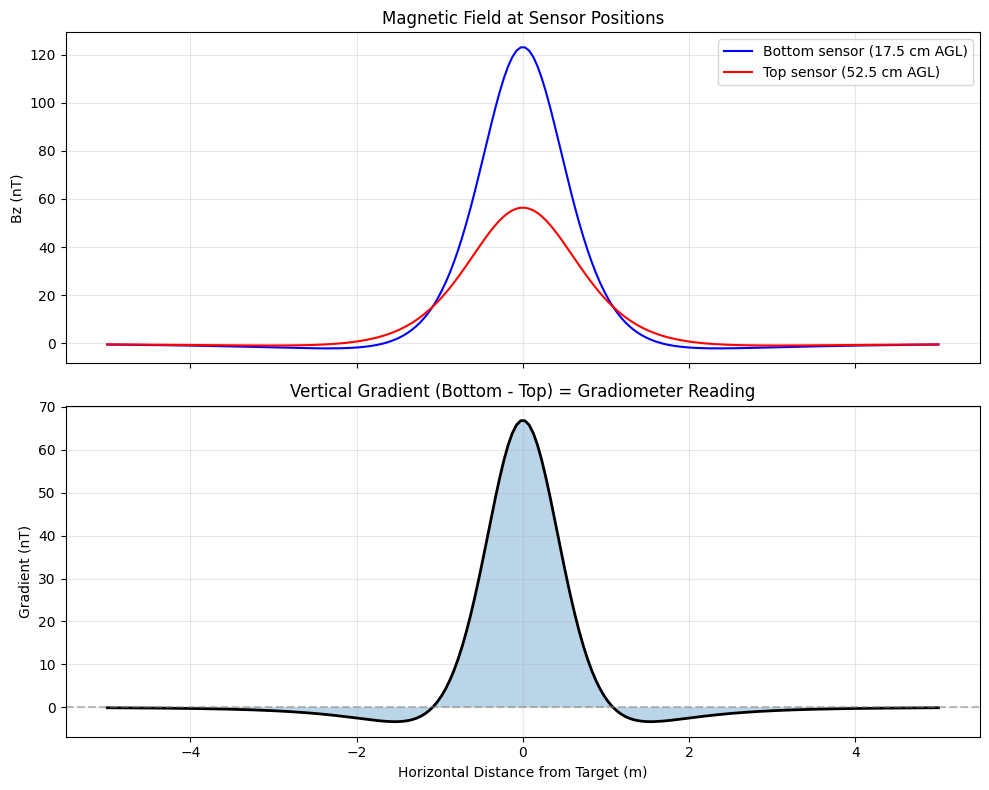

In [4]:
# Simulate a profile across a buried target
target_pos = np.array([0.0, 0.0, -1.0])  # 1m below surface
moment = np.array([0.0, 0.0, 1.0])  # 1 A·m²
separation = 0.35  # 35 cm baseline (Pathfinder spec)

x_profile = np.linspace(-5, 5, 200)
bottom_height = 0.175  # 17.5 cm above ground

r_bottom = np.column_stack([x_profile, np.zeros(200), np.full(200, bottom_height)])
r_top = r_bottom.copy()
r_top[:, 2] += separation

B_bottom = dipole_field(r_bottom, target_pos, moment)[:, 2]
B_top = dipole_field(r_top, target_pos, moment)[:, 2]
gradient = B_bottom - B_top

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(x_profile, B_bottom * 1e9, 'b-', label='Bottom sensor (17.5 cm AGL)')
ax1.plot(x_profile, B_top * 1e9, 'r-', label='Top sensor (52.5 cm AGL)')
ax1.set_ylabel('Bz (nT)')
ax1.set_title('Magnetic Field at Sensor Positions')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(x_profile, gradient * 1e9, 'k-', linewidth=2)
ax2.fill_between(x_profile, gradient * 1e9, alpha=0.3)
ax2.set_xlabel('Horizontal Distance from Target (m)')
ax2.set_ylabel('Gradient (nT)')
ax2.set_title('Vertical Gradient (Bottom - Top) = Gradiometer Reading')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()

## 4. Detection Depth vs. Target Size

How deep can Pathfinder detect a target? This depends on:
- **Target moment** (size × susceptibility × Earth field)
- **Sensor noise floor** (~50 pT for fluxgates)
- **Gradiometer baseline** (35 cm)

Target                 Radius       Moment  Detection Depth
------------------------------------------------------------
Nail (1cm)                1 cm      0.0005 A·m²          1.23 m
Rivet (2cm)               2 cm      0.0040 A·m²          1.86 m
Shell frag (5cm)          5 cm      0.0623 A·m²          3.23 m
Helmet (10cm)            10 cm      0.4985 A·m²          4.89 m
UXO (15cm)               15 cm      1.6825 A·m²          6.23 m
Engine (20cm)            20 cm      3.9880 A·m²          7.41 m


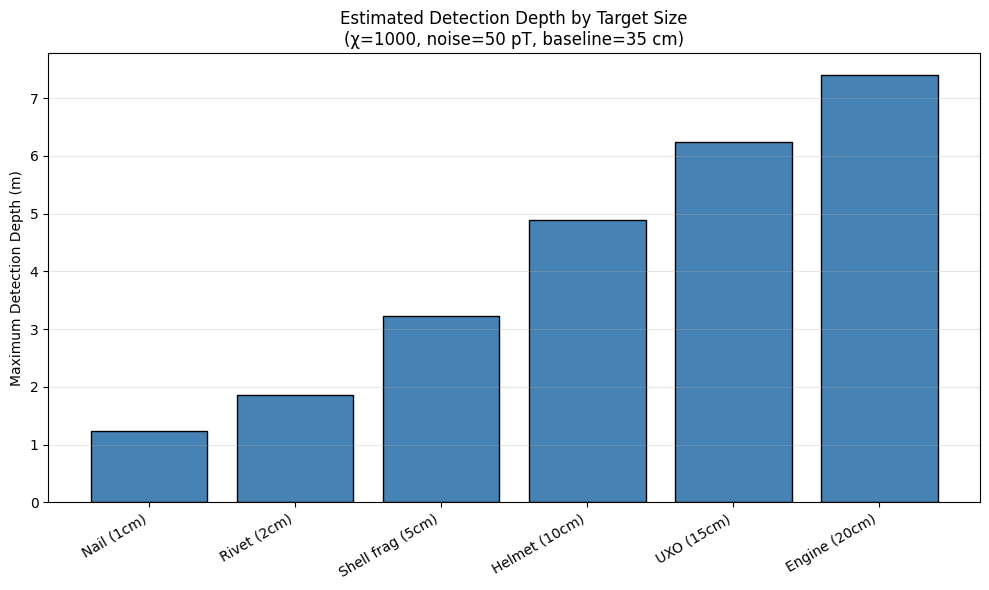

In [5]:
# Detection depth for various target sizes
radii = np.array([0.01, 0.02, 0.05, 0.10, 0.15, 0.20])  # meters
susceptibility = 1000.0  # mild steel
noise_floor = 50e-12  # 50 pT

labels = ['Nail (1cm)', 'Rivet (2cm)', 'Shell frag (5cm)',
          'Helmet (10cm)', 'UXO (15cm)', 'Engine (20cm)']

print(f"{'Target':<20} {'Radius':>8} {'Moment':>12} {'Detection Depth':>16}")
print('-' * 60)

depths = []
for r, label in zip(radii, labels):
    m = dipole_moment_from_sphere(r, susceptibility)
    m_mag = np.linalg.norm(m)
    depth = detection_depth_estimate(m_mag, noise_floor, 0.35)
    depths.append(depth)
    print(f"{label:<20} {r*100:>6.0f} cm  {m_mag:>10.4f} A·m²  {depth:>12.2f} m")

fig, ax = plt.subplots()
ax.bar(labels, depths, color='steelblue', edgecolor='black')
ax.set_ylabel('Maximum Detection Depth (m)')
ax.set_title('Estimated Detection Depth by Target Size\n(χ=1000, noise=50 pT, baseline=35 cm)')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

## 5. 2D Field Map

Visualize the vertical gradient field over a horizontal plane, simulating
what Pathfinder would see walking across a buried target.

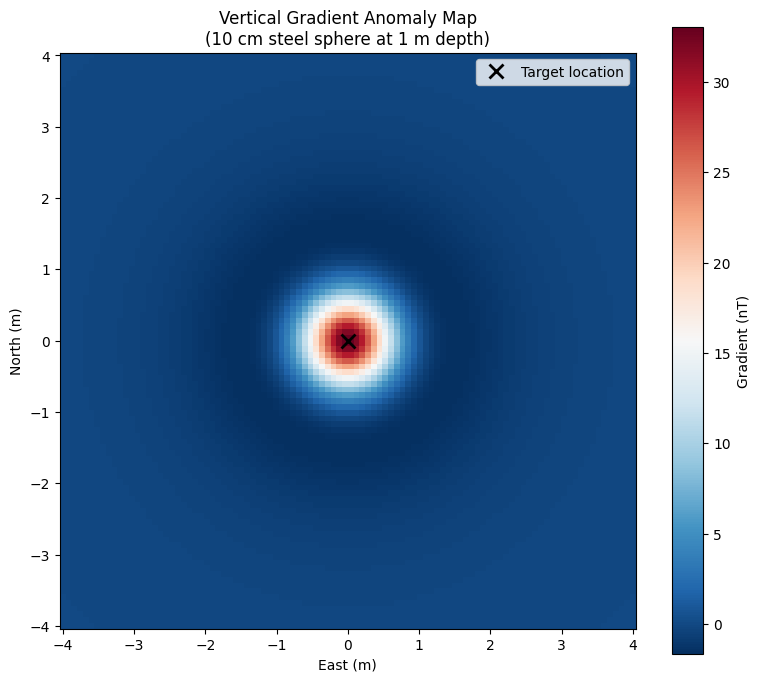

In [6]:
# Create a 2D grid at sensor height
target_pos = np.array([0.0, 0.0, -1.0])
moment = dipole_moment_from_sphere(0.10, 1000)  # 10 cm steel sphere

x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)

# Flatten grid, compute field, reshape
points = np.column_stack([X.ravel(), Y.ravel(), np.full(10000, 0.175)])
B_bot, B_top, grad = gradiometer_reading(
    points,
    [{'position': target_pos, 'moment': moment}],
    sensor_separation=0.35,
)

Grad_map = grad.reshape(100, 100) * 1e9  # to nT

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.pcolormesh(X, Y, Grad_map, cmap='RdBu_r', shading='auto')
ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Vertical Gradient Anomaly Map\n(10 cm steel sphere at 1 m depth)')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, label='Gradient (nT)')
ax.plot(0, 0, 'kx', markersize=10, markeredgewidth=2, label='Target location')
ax.legend()
plt.tight_layout()

## 6. Multiple Sources (Superposition)

Real sites have multiple buried objects. The total field is simply the
sum of individual dipole fields (superposition principle).

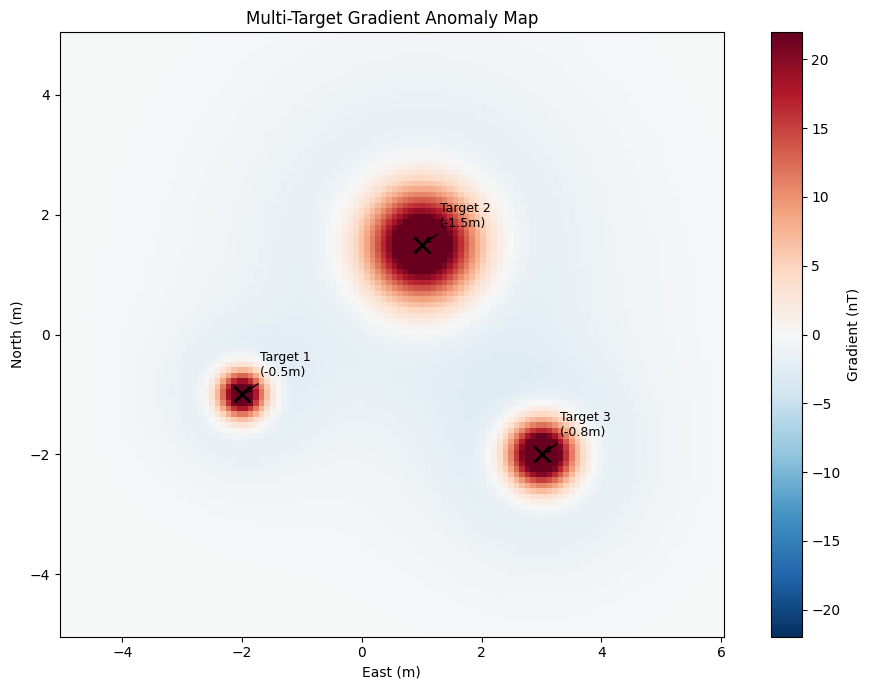

In [7]:
# Three buried targets at different positions and depths
sources = [
    {'position': np.array([-2.0, -1.0, -0.5]),
     'moment': dipole_moment_from_sphere(0.05, 800)},   # Shallow small target
    {'position': np.array([1.0, 1.5, -1.5]),
     'moment': dipole_moment_from_sphere(0.15, 1000)},  # Deep large target
    {'position': np.array([3.0, -2.0, -0.8]),
     'moment': dipole_moment_from_sphere(0.08, 600)},   # Medium target
]

x = np.linspace(-5, 6, 120)
y = np.linspace(-5, 5, 110)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel(), np.full(X.size, 0.175)])

r_upper = points.copy()
r_upper[:, 2] += 0.35

B_bot = superposition_field(points, sources)[:, 2]
B_top = superposition_field(r_upper, sources)[:, 2]
grad = (B_bot - B_top).reshape(X.shape) * 1e9

fig, ax = plt.subplots(figsize=(10, 7))
# Symmetric colorbar around zero
vmax = np.percentile(np.abs(grad), 99)
im = ax.pcolormesh(X, Y, grad, cmap='RdBu_r', vmin=-vmax, vmax=vmax, shading='auto')
ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Multi-Target Gradient Anomaly Map')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, label='Gradient (nT)')

# Mark target positions
for i, src in enumerate(sources):
    pos = src['position']
    ax.plot(pos[0], pos[1], 'kx', markersize=12, markeredgewidth=2)
    ax.annotate(f'Target {i+1}\n({pos[2]:.1f}m)', xy=(pos[0], pos[1]),
                xytext=(pos[0]+0.3, pos[1]+0.3), fontsize=9,
                arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()

## Key Takeaways

1. **Dipole field decays as 1/r³** — detection depth is fundamentally limited
2. **Gradiometer rejects uniform fields** — diurnal variation, regional gradients
3. **Gradient decays as ~1/r⁴** — sharper anomalies, better localization, but less range
4. **Target moment scales with volume** — 2× radius = 8× moment = significantly deeper detection
5. **Superposition** — multiple targets produce independent, additive anomalies
6. **3D structure** — isosurfaces reveal the dipole's characteristic "peanut" shape; gradient maps show the anomaly footprint at sensor height

Next: [02-pathfinder-simulation.ipynb](02-pathfinder-simulation.ipynb) — Full Pathfinder survey simulation

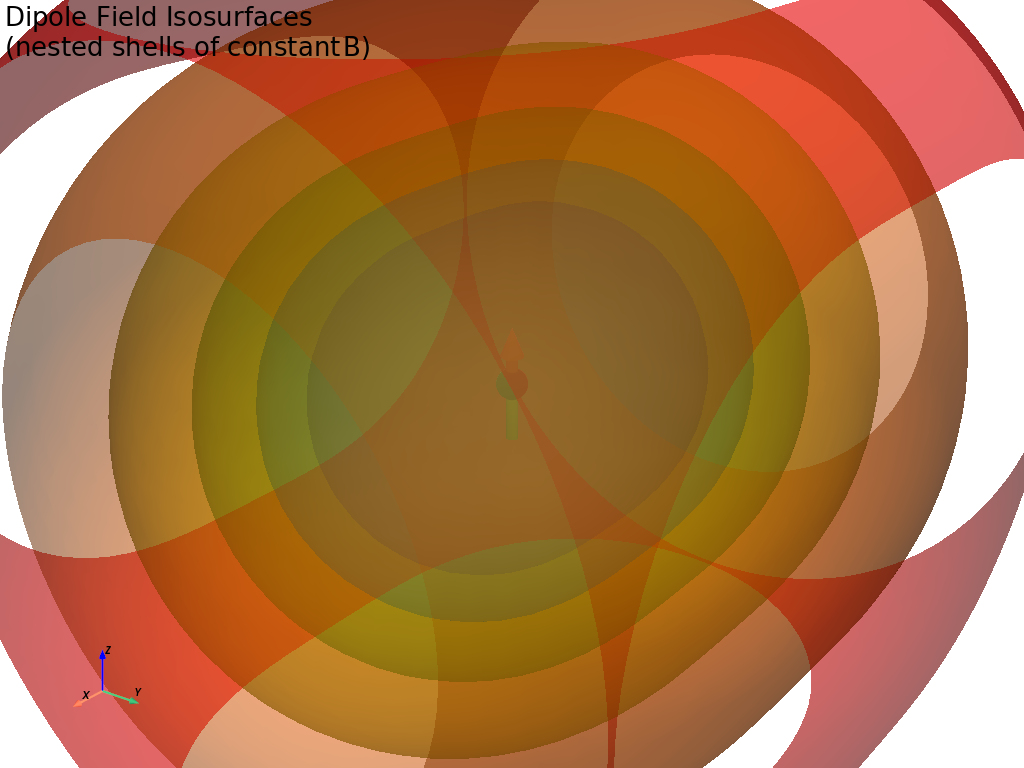

In [8]:
import pyvista as pv
from geosim.viz.fields import create_field_volume, create_isosurfaces

# For notebook rendering (static screenshots)
pv.set_jupyter_backend('static')

# Single dipole at origin
sources = [{'position': [0, 0, 0], 'moment': [0, 0, 1.0]}]

# Create 3D field volume
volume = create_field_volume(
    sources,
    bounds=(-2, 2, -2, 2, -2, 2),
    resolution=40,
    component="magnitude",
)

# Extract isosurfaces at different field strengths
isosurfaces = create_isosurfaces(volume, n_levels=6)

plotter = pv.Plotter(off_screen=True)
plotter.set_background('white')

# Add isosurfaces with decreasing opacity
colors = ['#FF0000', '#FF6600', '#FFCC00', '#66CC00', '#0099FF', '#6633CC']
for i, surf in enumerate(isosurfaces):
    opacity = 0.6 - i * 0.08
    color = colors[i] if i < len(colors) else 'gray'
    plotter.add_mesh(surf, color=color, opacity=max(opacity, 0.1), smooth_shading=True)

# Mark dipole location
plotter.add_mesh(pv.Sphere(radius=0.08, center=[0, 0, 0]), color='black')

# Add arrow showing moment direction
arrow = pv.Arrow(start=[0, 0, -0.3], direction=[0, 0, 1], scale=0.6)
plotter.add_mesh(arrow, color='yellow')

plotter.add_axes()
plotter.add_text('Dipole Field Isosurfaces\n(nested shells of constant |B|)',
                 font_size=12, position='upper_left')
plotter.camera_position = [(5, 4, 3), (0, 0, 0), (0, 0, 1)]
plotter.show()

## 8. 3D Gradient Map with Buried Target

Now let's visualize the gradient anomaly map in 3D, showing both the
colored surface at sensor height and the buried target beneath it. This
is what Pathfinder "sees" rendered in true 3D context.

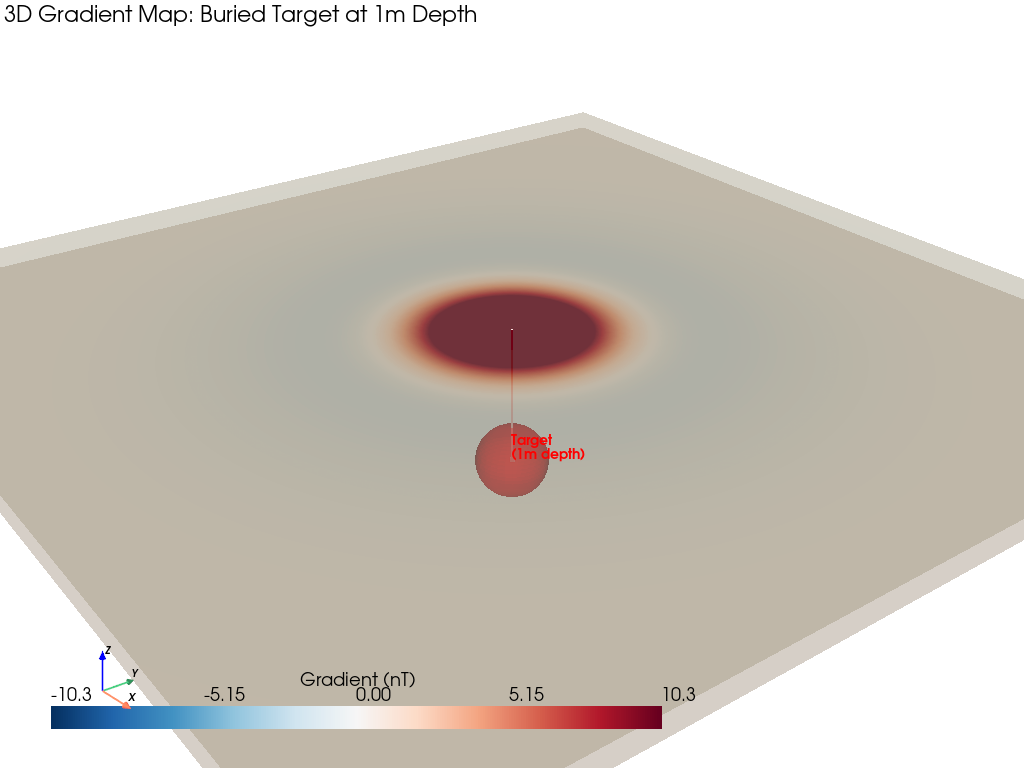

In [9]:
from geosim.viz.fields import create_gradient_surface

# Buried target: 10cm steel sphere at 1m depth
target_moment = dipole_moment_from_sphere(0.10, 1000)
sources = [{'position': [0.0, 0.0, -1.0], 'moment': target_moment}]

# Create gradient anomaly surface at sensor height
grad_surface = create_gradient_surface(
    sources,
    x_range=(-4, 4),
    y_range=(-4, 4),
    sensor_height=0.175,
    sensor_separation=0.35,
    resolution=100,
)

plotter = pv.Plotter(off_screen=True)
plotter.set_background('white')

# Ground plane (semi-transparent)
ground = pv.Plane(center=(0, 0, 0), direction=(0, 0, 1), i_size=8, j_size=8)
plotter.add_mesh(ground, color='#8B7355', opacity=0.3)

# Gradient anomaly map
vmax = np.percentile(np.abs(grad_surface['gradient_nT']), 98)
plotter.add_mesh(
    grad_surface,
    scalars='gradient_nT',
    cmap='RdBu_r',
    clim=[-vmax, vmax],
    opacity=0.85,
    scalar_bar_args={'title': 'Gradient (nT)', 'n_labels': 5,
                     'position_x': 0.05, 'position_y': 0.05},
)

# Buried target (transparent red sphere)
target_sphere = pv.Sphere(radius=0.3, center=[0, 0, -1.0])  # scaled 3x for visibility
plotter.add_mesh(target_sphere, color='red', opacity=0.6)

# Dashed line from target to surface (vertical projection)
line = pv.Line([0, 0, -1.0], [0, 0, 0.175])
plotter.add_mesh(line, color='red', line_width=2, style='wireframe')

# Labels
plotter.add_point_labels(
    [[0, 0, -1.0]], ['Target\n(1m depth)'],
    font_size=14, point_color='red', text_color='red',
    shape=None, always_visible=True,
)

plotter.add_axes()
plotter.add_text('3D Gradient Map: Buried Target at 1m Depth',
                 font_size=12, position='upper_left')
plotter.camera_position = [(8, -6, 5), (0, 0, -0.3), (0, 0, 1)]
plotter.show()

## 9. From Synthetic Examples to Scenario Files

So far we've built dipoles by hand. In practice, GeoSim uses **scenario JSON files**
that define buried objects, terrain, and soil properties. The scenario loader
automatically computes induced magnetic moments from each object's radius,
susceptibility, and the Earth field — exactly the same physics we derived above.

Let's load the `single-ferrous-target` scenario and verify the math matches.

In [ ]:
from pathlib import Path
from geosim.scenarios.loader import load_scenario

scenario = load_scenario(Path('..') / 'scenarios' / 'single-ferrous-target.json')
obj = scenario.objects[0]

print(f'Scenario: {scenario.name}')
print(f'Object:   {obj.name}')
print(f'Position: {obj.position} m')
print(f'Radius:   {obj.radius} m')
print(f'Chi:      {obj.susceptibility}')
print(f'Earth B:  {scenario.earth_field * 1e6} uT  (|B| = {np.linalg.norm(scenario.earth_field)*1e6:.1f} uT)')
print(f'\nAuto-computed moment: {obj.moment}')
print(f'|m| = {np.linalg.norm(obj.moment):.6f} A*m^2')

In [ ]:
# Compare the scenario's auto-computed moment to our manual calculation
manual_moment = dipole_moment_from_sphere(
    radius=obj.radius,
    susceptibility=obj.susceptibility,
    B_earth=np.linalg.norm(scenario.earth_field),
)

# The scenario loader uses the full Earth field vector direction,
# so the moment direction differs from our z-only default
print('Manual dipole_moment_from_sphere():')
print(f'  moment = {manual_moment}')
print(f'  |m|    = {np.linalg.norm(manual_moment):.6f} A*m^2')
print()
print('Scenario auto-computed moment:')
print(f'  moment = {obj.moment}')
print(f'  |m|    = {np.linalg.norm(obj.moment):.6f} A*m^2')
print()

# The magnitudes should agree (same physics, different direction convention)
ratio = np.linalg.norm(obj.moment) / np.linalg.norm(manual_moment)
print(f'Magnitude ratio: {ratio:.10f}  (should be ~1.0)')
print(f'Match: {"YES" if abs(ratio - 1.0) < 0.01 else "NO"}')

### Validating Against Analytical Formulas

The scenario loader's `compute_induced_moments()` uses the same effective susceptibility
formula we derived in Section 4: $m = V \cdot \frac{3\chi}{\chi+3} \cdot \frac{B_{\text{earth}}}{\mu_0}$.
Let's verify this end-to-end: compute the field from the scenario's sources and compare
to the analytical dipole formula evaluated directly.

In [ ]:
# Compute gradient profile across the scenario target using the scenario loader's sources
sources = scenario.magnetic_sources
target_pos = scenario.objects[0].position

x_profile = np.linspace(target_pos[0] - 5, target_pos[0] + 5, 200)
r_bottom = np.column_stack([
    x_profile,
    np.full(200, target_pos[1]),
    np.full(200, 0.175),
])

B_bot, B_top, gradient = gradiometer_reading(
    r_bottom, sources, sensor_separation=0.35,
)

# Also compute analytically from the manual moment for comparison
B_bot_manual, B_top_manual, gradient_manual = gradiometer_reading(
    r_bottom,
    [{'position': target_pos, 'moment': manual_moment}],
    sensor_separation=0.35,
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax1.plot(x_profile - target_pos[0], gradient * 1e9, 'b-', lw=2, label='Scenario sources')
ax1.plot(x_profile - target_pos[0], gradient_manual * 1e9, 'r--', lw=1.5, label='Manual moment (z-only)')
ax1.set_ylabel('Gradient (nT)')
ax1.set_title(f'Gradient Profile: {scenario.name}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Show residual (difference between direction conventions)
residual = (gradient - gradient_manual) * 1e9
ax2.plot(x_profile - target_pos[0], residual, 'g-', lw=1)
ax2.set_xlabel('Distance from target (m)')
ax2.set_ylabel('Residual (nT)')
ax2.set_title('Difference: scenario (tilted moment) vs manual (z-only moment)')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='gray', ls='--', alpha=0.5)
plt.tight_layout()

In [ ]:
# Estimate detection depth for this target
m_mag = np.linalg.norm(obj.moment)
noise_floor = 50e-12  # 50 pT Pathfinder noise floor
depth_est = detection_depth_estimate(m_mag, noise_floor, 0.35)

actual_depth = abs(obj.position[2])
peak_gradient = np.max(np.abs(gradient))

print(f'Target: {obj.name}')
print(f'  Moment magnitude: {m_mag:.4f} A*m^2')
print(f'  Actual depth:     {actual_depth:.1f} m')
print(f'  Estimated max detection depth: {depth_est:.2f} m')
print(f'  Peak gradient at surface: {peak_gradient*1e9:.2f} nT')
print(f'  Detectable: {"YES" if actual_depth < depth_est else "NO"}'
      f' (depth {actual_depth:.1f}m < limit {depth_est:.1f}m)')

The scenario loader automates the physics we explored manually. The small residual
between the tilted (scenario) and z-only (manual) moments shows that **moment
direction matters** — the Earth field at mid-latitudes is inclined ~65°, so a
properly induced moment has both horizontal and vertical components.

Next: [02-pathfinder-simulation.ipynb](02-pathfinder-simulation.ipynb) — Full Pathfinder survey simulation with walk paths and noise